# Policy Gradient Methods in Reinforcement Learning

## 1. Introduction

Policy gradient methods are a class of reinforcement learning algorithms that directly optimize the policy without requiring a value function. Unlike value-based methods (e.g., Q-learning), policy gradient methods parameterize the policy and update it by gradient ascent on expected cumulative reward.

## 2. Theoretical Foundation

### 2.1 Policy Parameterization

We define a stochastic policy $\pi_\theta(a|s)$ parameterized by $\theta$, which gives the probability of taking action $a$ in state $s$. The objective is to maximize the expected return:

$$J(\theta) = \mathbb{E}_{\tau \sim \pi_\theta} \left[ \sum_{t=0}^{T} \gamma^t r_t \right]$$

where $\tau = (s_0, a_0, r_0, s_1, a_1, r_1, \ldots)$ is a trajectory, and $\gamma \in [0, 1]$ is the discount factor.

### 2.2 Policy Gradient Theorem

The policy gradient theorem provides a tractable expression for the gradient of $J(\theta)$:

$$\nabla_\theta J(\theta) = \mathbb{E}_{\tau \sim \pi_\theta} \left[ \sum_{t=0}^{T} \nabla_\theta \log \pi_\theta(a_t|s_t) \cdot G_t \right]$$

where $G_t = \sum_{k=t}^{T} \gamma^{k-t} r_k$ is the return from time step $t$.

### 2.3 REINFORCE Algorithm

The REINFORCE algorithm (Williams, 1992) is a Monte Carlo policy gradient method:

1. Sample trajectory $\tau$ using policy $\pi_\theta$
2. Compute returns $G_t$ for each time step
3. Update: $\theta \leftarrow \theta + \alpha \sum_{t=0}^{T} \nabla_\theta \log \pi_\theta(a_t|s_t) \cdot G_t$

### 2.4 Variance Reduction with Baseline

To reduce variance, we subtract a baseline $b(s_t)$ from the return:

$$\nabla_\theta J(\theta) = \mathbb{E}_{\tau \sim \pi_\theta} \left[ \sum_{t=0}^{T} \nabla_\theta \log \pi_\theta(a_t|s_t) \cdot (G_t - b(s_t)) \right]$$

A common choice is the average return: $b = \frac{1}{N} \sum_{i=1}^{N} G_0^{(i)}$

The term $(G_t - b(s_t))$ is called the **advantage**.

## 3. Implementation

We will implement the REINFORCE algorithm to solve a simple continuous control problem: balancing a pole (CartPole-like environment simulated from scratch).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import softmax

np.random.seed(42)

### 3.1 Environment: Simplified CartPole

We implement a simplified CartPole environment with discrete actions (left/right force).

In [2]:
class CartPoleEnv:
    """Simplified CartPole environment."""
    
    def __init__(self):
        # Physical parameters
        self.gravity = 9.8
        self.cart_mass = 1.0
        self.pole_mass = 0.1
        self.total_mass = self.cart_mass + self.pole_mass
        self.pole_length = 0.5
        self.pole_mass_length = self.pole_mass * self.pole_length
        self.force_mag = 10.0
        self.dt = 0.02
        
        # Thresholds for termination
        self.x_threshold = 2.4
        self.theta_threshold = 12 * np.pi / 180  # 12 degrees
        
        self.state = None
        self.steps = 0
        self.max_steps = 200
        
    def reset(self):
        """Reset the environment."""
        self.state = np.random.uniform(-0.05, 0.05, size=4)
        self.steps = 0
        return self.state.copy()
    
    def step(self, action):
        """Take a step in the environment."""
        x, x_dot, theta, theta_dot = self.state
        
        # Apply force based on action
        force = self.force_mag if action == 1 else -self.force_mag
        
        # Physics simulation
        cos_theta = np.cos(theta)
        sin_theta = np.sin(theta)
        
        temp = (force + self.pole_mass_length * theta_dot**2 * sin_theta) / self.total_mass
        theta_acc = (self.gravity * sin_theta - cos_theta * temp) / \
                    (self.pole_length * (4/3 - self.pole_mass * cos_theta**2 / self.total_mass))
        x_acc = temp - self.pole_mass_length * theta_acc * cos_theta / self.total_mass
        
        # Euler integration
        x = x + self.dt * x_dot
        x_dot = x_dot + self.dt * x_acc
        theta = theta + self.dt * theta_dot
        theta_dot = theta_dot + self.dt * theta_acc
        
        self.state = np.array([x, x_dot, theta, theta_dot])
        self.steps += 1
        
        # Check termination
        done = bool(
            x < -self.x_threshold or x > self.x_threshold or
            theta < -self.theta_threshold or theta > self.theta_threshold or
            self.steps >= self.max_steps
        )
        
        reward = 1.0 if not done else 0.0
        
        return self.state.copy(), reward, done

### 3.2 Policy Network

We use a simple linear policy with softmax action selection:

$$\pi_\theta(a|s) = \text{softmax}(W \cdot s + b)$$

In [3]:
class PolicyNetwork:
    """Linear policy network with softmax output."""
    
    def __init__(self, state_dim, action_dim):
        self.state_dim = state_dim
        self.action_dim = action_dim
        
        # Initialize weights
        self.W = np.random.randn(action_dim, state_dim) * 0.1
        self.b = np.zeros(action_dim)
        
    def forward(self, state):
        """Compute action probabilities."""
        logits = np.dot(self.W, state) + self.b
        probs = softmax(logits)
        return probs
    
    def select_action(self, state):
        """Sample action from policy."""
        probs = self.forward(state)
        action = np.random.choice(self.action_dim, p=probs)
        return action, probs
    
    def compute_log_prob_grad(self, state, action, probs):
        """Compute gradient of log probability."""
        # Gradient of log softmax
        # d/dθ log π(a|s) = d/dθ (logits[a] - logsumexp(logits))
        # = indicator(a) - softmax(logits)
        
        grad_logits = -probs.copy()
        grad_logits[action] += 1
        
        # Gradient w.r.t. W and b
        grad_W = np.outer(grad_logits, state)
        grad_b = grad_logits
        
        return grad_W, grad_b
    
    def update(self, grad_W, grad_b, learning_rate):
        """Update policy parameters."""
        self.W += learning_rate * grad_W
        self.b += learning_rate * grad_b

### 3.3 REINFORCE Algorithm with Baseline

In [4]:
def reinforce(env, policy, num_episodes=1000, gamma=0.99, learning_rate=0.01):
    """REINFORCE algorithm with baseline."""
    
    episode_rewards = []
    baseline = 0  # Running average of returns
    
    for episode in range(num_episodes):
        # Collect trajectory
        states, actions, rewards, probs_list = [], [], [], []
        state = env.reset()
        done = False
        
        while not done:
            action, probs = policy.select_action(state)
            next_state, reward, done = env.step(action)
            
            states.append(state)
            actions.append(action)
            rewards.append(reward)
            probs_list.append(probs)
            
            state = next_state
        
        # Compute returns
        T = len(rewards)
        returns = np.zeros(T)
        G = 0
        for t in reversed(range(T)):
            G = rewards[t] + gamma * G
            returns[t] = G
        
        # Update baseline (moving average)
        episode_return = returns[0]
        baseline = 0.9 * baseline + 0.1 * episode_return
        
        # Compute policy gradient
        total_grad_W = np.zeros_like(policy.W)
        total_grad_b = np.zeros_like(policy.b)
        
        for t in range(T):
            advantage = returns[t] - baseline
            grad_W, grad_b = policy.compute_log_prob_grad(
                states[t], actions[t], probs_list[t]
            )
            total_grad_W += advantage * grad_W
            total_grad_b += advantage * grad_b
        
        # Update policy
        policy.update(total_grad_W / T, total_grad_b / T, learning_rate)
        
        episode_rewards.append(sum(rewards))
        
        if (episode + 1) % 100 == 0:
            avg_reward = np.mean(episode_rewards[-100:])
            print(f"Episode {episode + 1}, Avg Reward (last 100): {avg_reward:.2f}")
    
    return episode_rewards

### 3.4 Training

In [5]:
# Initialize environment and policy
env = CartPoleEnv()
policy = PolicyNetwork(state_dim=4, action_dim=2)

# Train using REINFORCE
print("Training REINFORCE with Baseline...\n")
rewards = reinforce(env, policy, num_episodes=1000, gamma=0.99, learning_rate=0.01)

Training REINFORCE with Baseline...

Episode 100, Avg Reward (last 100): 37.30


Episode 200, Avg Reward (last 100): 50.79


Episode 300, Avg Reward (last 100): 91.34


Episode 400, Avg Reward (last 100): 122.35


Episode 500, Avg Reward (last 100): 150.99


Episode 600, Avg Reward (last 100): 166.02


Episode 700, Avg Reward (last 100): 182.86


Episode 800, Avg Reward (last 100): 175.07


Episode 900, Avg Reward (last 100): 182.62


Episode 1000, Avg Reward (last 100): 182.90


## 4. Results and Visualization

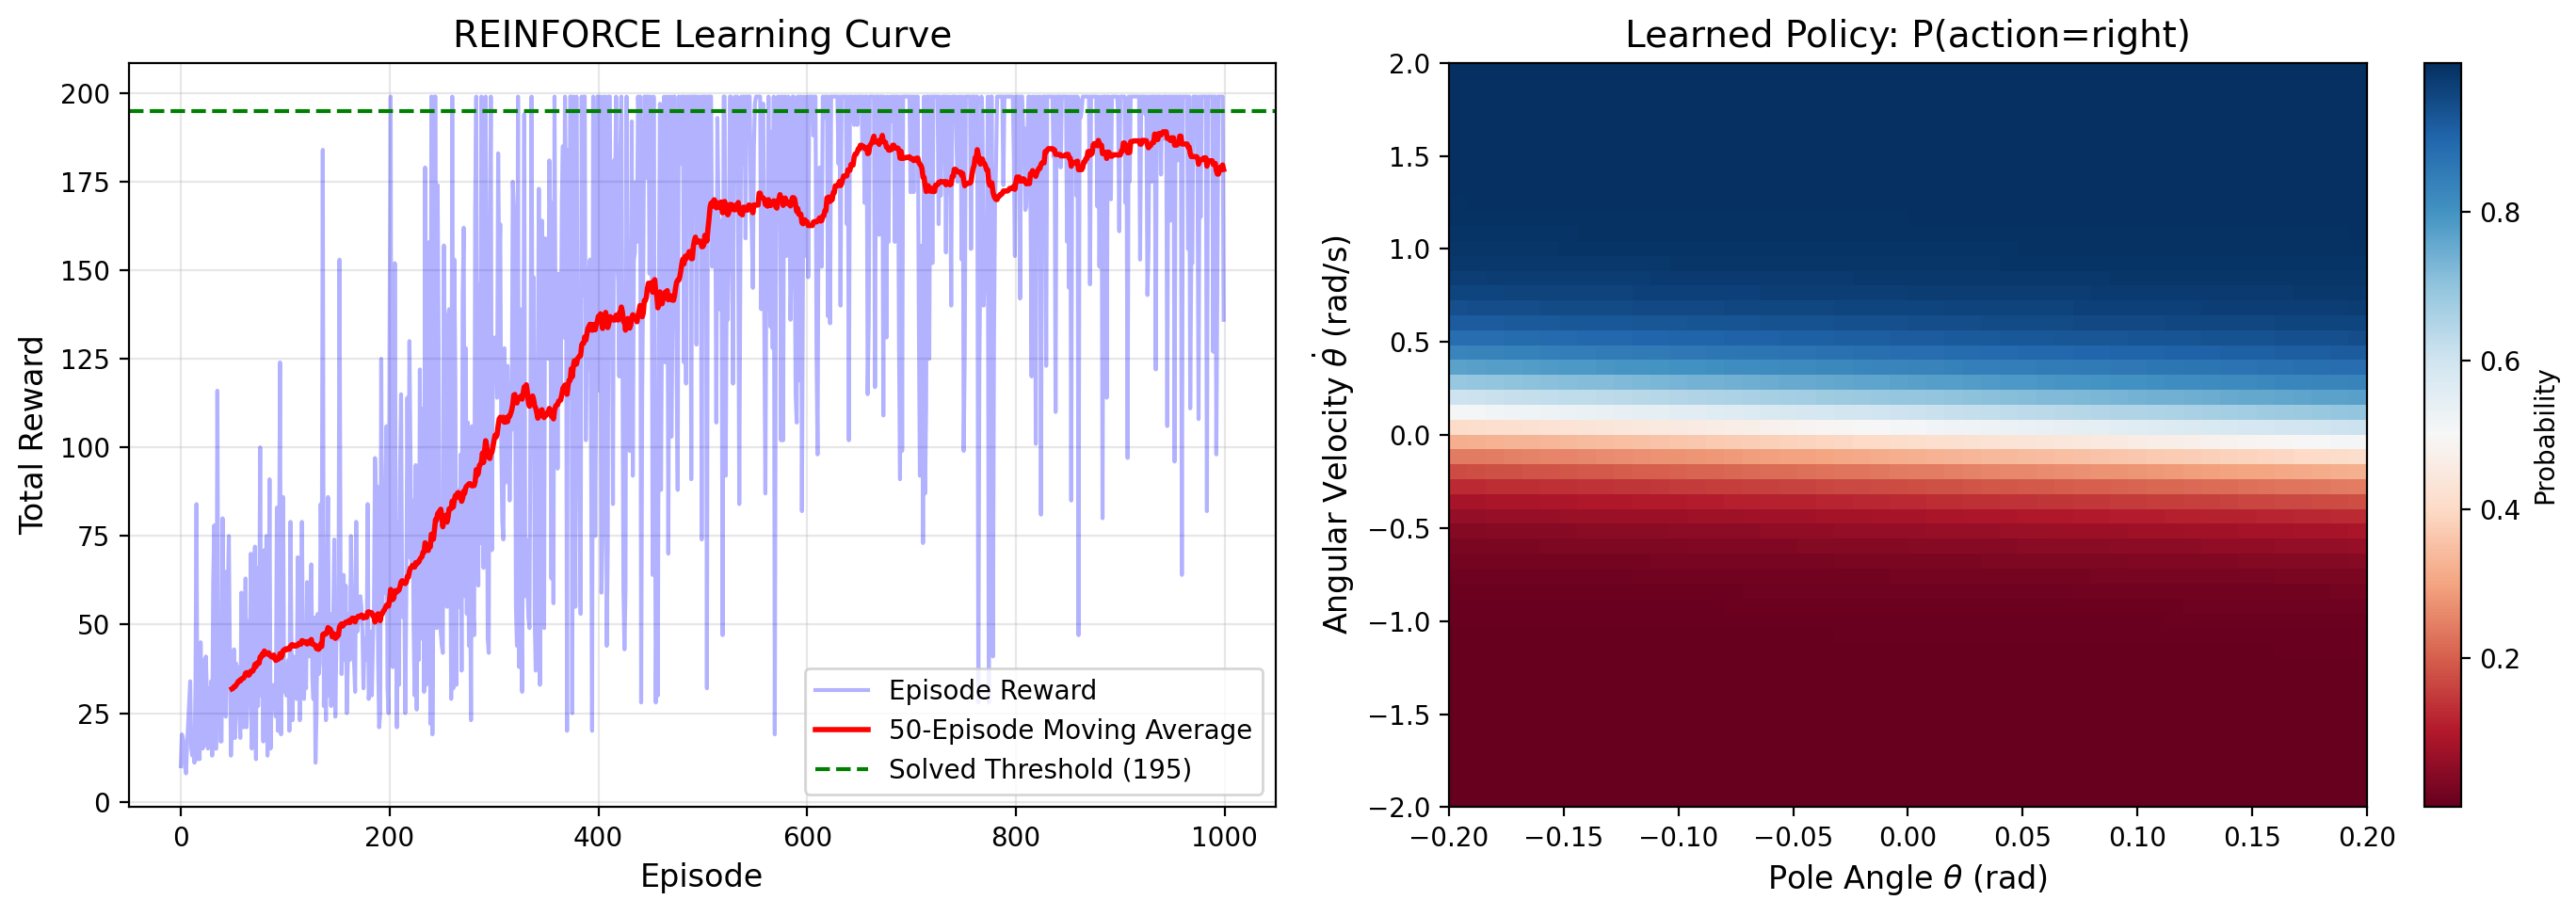


Final average reward (last 100 episodes): 182.90
Plot saved to 'plot.png'


In [6]:
# Compute moving average
window = 50
moving_avg = np.convolve(rewards, np.ones(window)/window, mode='valid')

# Create figure
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Learning Curve
axes[0].plot(rewards, alpha=0.3, color='blue', label='Episode Reward')
axes[0].plot(range(window-1, len(rewards)), moving_avg, color='red', 
             linewidth=2, label=f'{window}-Episode Moving Average')
axes[0].axhline(y=195, color='green', linestyle='--', label='Solved Threshold (195)')
axes[0].set_xlabel('Episode', fontsize=12)
axes[0].set_ylabel('Total Reward', fontsize=12)
axes[0].set_title('REINFORCE Learning Curve', fontsize=14)
axes[0].legend(loc='lower right')
axes[0].grid(True, alpha=0.3)

# Plot 2: Policy Visualization
# Visualize learned policy over state space (theta vs theta_dot)
theta_range = np.linspace(-0.2, 0.2, 50)
theta_dot_range = np.linspace(-2, 2, 50)
policy_map = np.zeros((50, 50))

for i, theta in enumerate(theta_range):
    for j, theta_dot in enumerate(theta_dot_range):
        state = np.array([0, 0, theta, theta_dot])  # x=0, x_dot=0
        probs = policy.forward(state)
        policy_map[j, i] = probs[1]  # Probability of action 1 (right)

im = axes[1].imshow(policy_map, extent=[-0.2, 0.2, -2, 2], 
                    origin='lower', aspect='auto', cmap='RdBu')
axes[1].set_xlabel(r'Pole Angle $\theta$ (rad)', fontsize=12)
axes[1].set_ylabel(r'Angular Velocity $\dot{\theta}$ (rad/s)', fontsize=12)
axes[1].set_title('Learned Policy: P(action=right)', fontsize=14)
cbar = plt.colorbar(im, ax=axes[1])
cbar.set_label('Probability', fontsize=10)

plt.tight_layout()
plt.savefig('policy_gradient_methods_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nFinal average reward (last 100 episodes): {np.mean(rewards[-100:]):.2f}")
print("Plot saved to 'plot.png'")

## 5. Analysis

### 5.1 Observations

1. **Learning Dynamics**: The REINFORCE algorithm shows high variance in episode rewards due to its Monte Carlo nature. The baseline helps reduce this variance.

2. **Policy Interpretation**: The learned policy shows intuitive behavior:
   - When $\theta > 0$ (pole falling right), the agent applies rightward force
   - When $\dot{\theta} > 0$ (pole rotating right), similar corrective action
   - The policy learns a smooth interpolation between these cases

### 5.2 Advantages and Limitations

**Advantages:**
- Can learn stochastic policies
- Naturally handles continuous action spaces
- Convergence guarantees to local optima

**Limitations:**
- High variance in gradient estimates
- Sample inefficient (requires many trajectories)
- Sensitive to hyperparameters

### 5.3 Extensions

Modern policy gradient methods address these limitations:
- **Actor-Critic**: Use learned value function as baseline
- **PPO/TRPO**: Constrain policy updates for stability
- **A3C/A2C**: Parallel sampling for efficiency

## 6. Conclusion

Policy gradient methods provide a principled approach to directly optimizing policies in reinforcement learning. The REINFORCE algorithm, while simple, demonstrates the core ideas:

1. **Direct policy optimization** via gradient ascent on expected return
2. **Variance reduction** through baseline subtraction
3. **Stochastic exploration** naturally encoded in the policy

These foundations underpin modern deep RL algorithms like PPO, SAC, and TD3 that achieve state-of-the-art performance in complex control tasks.